# Market prediction using Flux.jl

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Market-prediction-using-Flux.jl" data-toc-modified-id="Market-prediction-using-Flux.jl-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Market prediction using Flux.jl</a></span><ul class="toc-item"><li><span><a href="#Libraries-used-in-this-notebook" data-toc-modified-id="Libraries-used-in-this-notebook-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Libraries used in this notebook</a></span></li></ul></li><li><span><a href="#Define-Hyperparameters" data-toc-modified-id="Define-Hyperparameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define Hyperparameters</a></span></li><li><span><a href="#Load--Data" data-toc-modified-id="Load--Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load  Data</a></span><ul class="toc-item"><li><span><a href="#ISM-Manufacturing-Employment" data-toc-modified-id="ISM-Manufacturing-Employment-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ISM Manufacturing Employment</a></span></li><li><span><a href="#Markit---Manufacturing-PMI" data-toc-modified-id="Markit---Manufacturing-PMI-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Markit - Manufacturing PMI</a></span></li></ul></li><li><span><a href="#Visualize-the-Data" data-toc-modified-id="Visualize-the-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualize the Data</a></span><ul class="toc-item"><li><span><a href="#Plotting-Data" data-toc-modified-id="Plotting-Data-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Plotting Data</a></span></li></ul></li><li><span><a href="#Shift-Employment-by-90-days-back" data-toc-modified-id="Shift-Employment-by-90-days-back-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Shift Employment by 90 days back</a></span></li><li><span><a href="#Extract-Data" data-toc-modified-id="Extract-Data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Extract Data</a></span><ul class="toc-item"><li><span><a href="#Extract-Independent-Variables-(i.e.-features)" data-toc-modified-id="Extract-Independent-Variables-(i.e.-features)-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Extract Independent Variables (i.e. features)</a></span></li><li><span><a href="#Extract-Dependent-Variable-(i.e.-price)" data-toc-modified-id="Extract-Dependent-Variable-(i.e.-price)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Extract Dependent Variable (i.e. price)</a></span></li></ul></li><li><span><a href="#Normalize-the-data" data-toc-modified-id="Normalize-the-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Normalize the data</a></span><ul class="toc-item"><li><span><a href="#Show-mean()-values" data-toc-modified-id="Show-mean()-values-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Show mean() values</a></span></li><li><span><a href="#Show-std()-values" data-toc-modified-id="Show-std()-values-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Show std() values</a></span></li><li><span><a href="#Normalize-the-independent-variables" data-toc-modified-id="Normalize-the-independent-variables-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Normalize the independent variables</a></span></li></ul></li><li><span><a href="#Mean-Squared-Error-(MSE)" data-toc-modified-id="Mean-Squared-Error-(MSE)-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Mean Squared Error (MSE)</a></span></li></ul></div>

## Libraries used in this notebook

Uncomment the lines below if you are missing given libraries, or you want to update to the newest version.

**Warning:** the updates and required pre-compiling will take a lot of time time.

In [1]:
# import Pkg; Pkg.add("Flux")
using Flux

# import Pkg; Pkg.add("DelimitedFiles")
using DelimitedFiles

# import Pkg; Pkg.add("Statistics")
using Statistics

# import Pkg; Pkg.add("Flux")
using Flux.Optimise: update!

# import Pkg; Pkg.add("Parameters")
#using Parameters #: @with_kw

# import Pkg; Pkg.add("Plots")
using Plots

# import Pkg; Pkg.add("DataFrames")
using DataFrames

# import Pkg; Pkg.add("CSV")
using CSV

# import Pkg; Pkg.add("Dates")
using Dates

In [87]:
# include function that are used in this project
include("MarketIndicators.jl")

Functions available:
df = fetch_data(file_path, date_format="yyyy-mm-dd" )
df = shift_dates_by_days!(df, shift_days=-1, date_column=1)


shift_dates_by_days! (generic function with 6 methods)

In [2]:
 println( "Last update: ", Dates.format(Dates.now(), "u. d, yyyy HH:mm"))

Last update: Sep. 3, 2020 07:09


# Define Hyperparameters

In [6]:
learning_rate = 0.1       # learning rate
split_ratio = 0.1         # train/test split ratio 0.1 => 90/10

file_ISM_Mfc_Emp = "data/united-states.ism-manufacturing-employment.csv"
file_Markkit_Mfc_PMI = "data/united-states.markit-manufacturing-pmi.csv"

"data/united-states.markit-manufacturing-pmi.csv"

# Load  Data


## ISM Manufacturing Employment

In [13]:
df_ISM_Mfc_Emp = fetch_data(file_ISM_Mfc_Emp, "yyyy.mm.dd")

,Date,ActualValue,ForecastValue,PreviousValue
,Date,Float64,Float64?,Float64?
1,2020-08-03,44.3,34.4,42.1
2,2020-07-01,42.1,38.1,32.1
3,2020-06-01,32.1,34.1,27.5
4,2020-05-01,27.5,44.8,43.8
5,2020-04-01,43.8,45.4,46.9
6,2020-03-02,46.9,43.9,46.6
7,2020-02-03,46.6,43.3,45.2
8,2020-01-03,45.1,53.5,46.6
9,2019-12-02,46.6,54.3,47.7


## Markit - Manufacturing PMI

In [15]:
df_Markkit_Mfc_PMI = fetch_data(file_Markkit_Mfc_PMI, "yyyy.mm.dd")

,Date,ActualValue,ForecastValue,PreviousValue
,Date,Float64,Float64?,Float64?
1,2020-08-21,53.6,51.1,50.9
2,2020-08-03,50.9,51.3,51.3
3,2020-07-24,51.3,49.7,49.8
4,2020-07-01,49.8,49.6,49.6
5,2020-06-23,49.6,42.3,39.8
6,2020-06-01,39.8,39.8,39.8
7,2020-05-21,39.8,37.9,36.1
8,2020-05-01,36.1,36.9,36.9
9,2020-04-23,36.9,47.5,48.5


# Visualize the Data

Visualization of the data is important to identify:
- possible correlations (patterns)
- missing data (e.g. before certain date)
- wrong types of data (text vs. numbers, etc.)

## Plotting Data

2020-08-21 to 2012-04-25


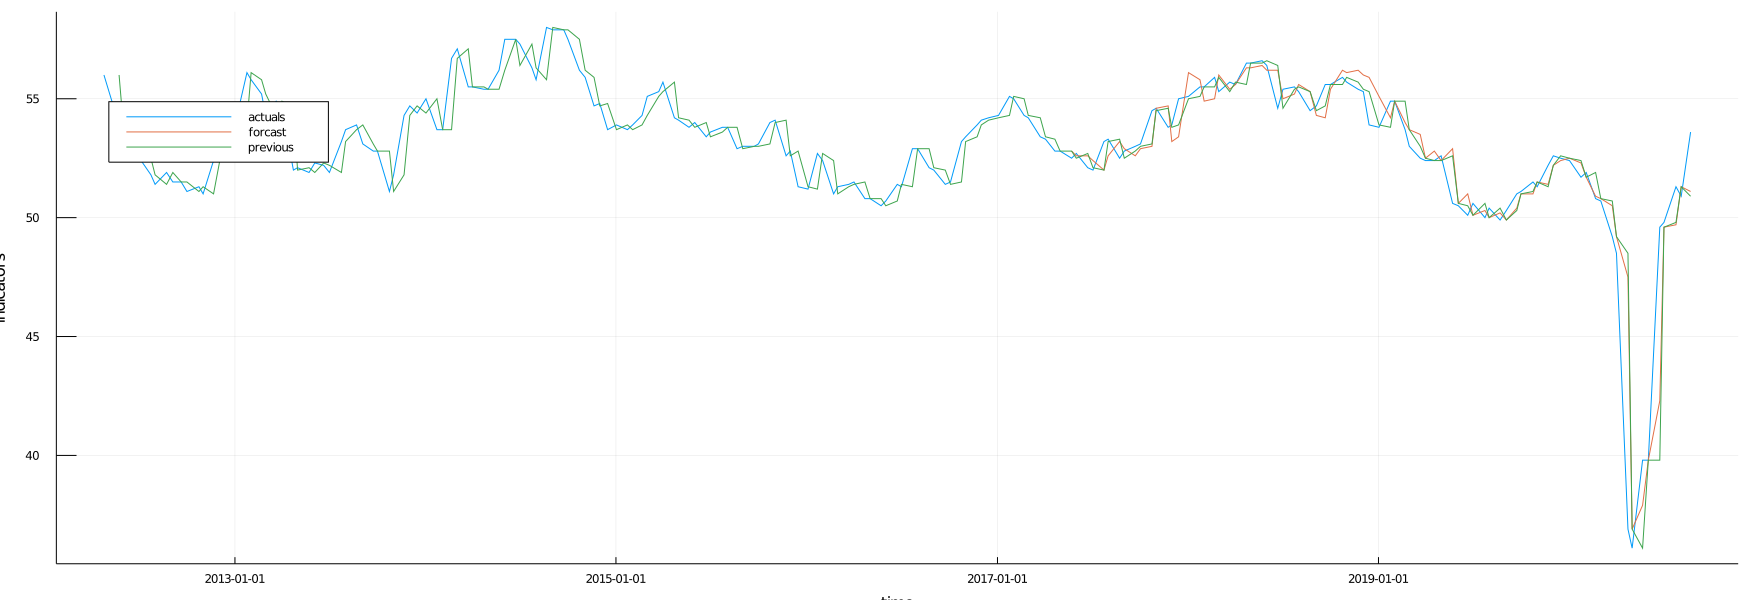

In [59]:
df = df_Markkit_Mfc_PMI
periods = df[:,1] # all rows, first column
println(periods[begin], " to ", periods[end])
gr()
plot(periods, 
    [df[:,2]  df[:,3] df[:,4] ], 
    label    = ["actuals" "forcast" "previous"],
    legend    =:topleft, # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (1750, 600), # width, height
    layout = (1, 1) # number of seperate plots VERTICALLY, HORIZONTALLY
    )

2020-08-03 to 2013-11-01


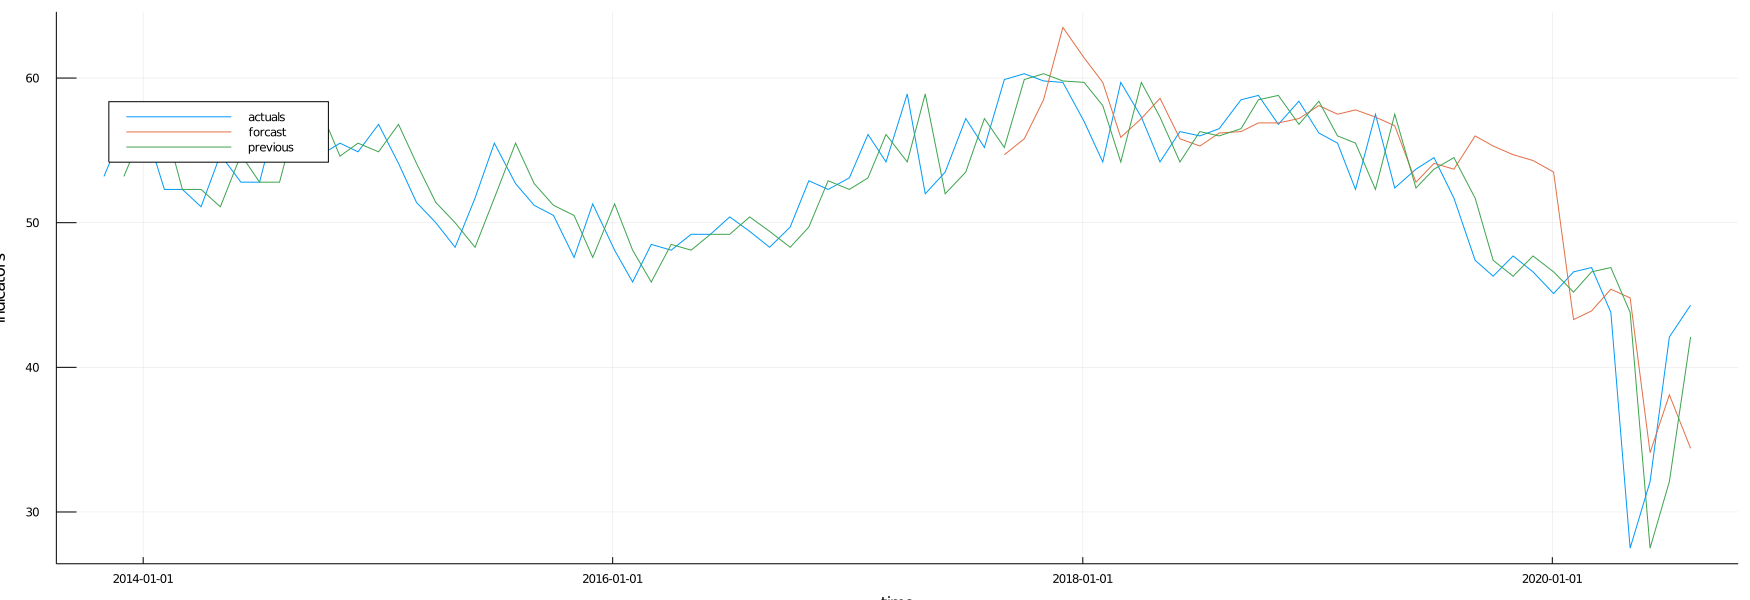

In [60]:
df = df_ISM_Mfc_Emp
periods = df[:,1] # all rows, first column
println(periods[begin], " to ", periods[end])
gr()
plot(periods, 
    [df[:,2]  df[:,3] df[:,4] ], 
    label    = ["actuals" "forcast" "previous"],
    legend    =:topleft, # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (1750, 600), # width, height
    layout = (1, 1) # number of seperate plots VERTICALLY, HORIZONTALLY
    )

In [63]:
df1 = df_ISM_Mfc_Emp[:,1:2] # all rows, columns: Date and Actuals
size(df1)

(82, 2)

In [66]:
df2 = df_Markkit_Mfc_PMI[end-81:end,1:2] # last 82 rows, columns: Date and Actuals
size(df2)

(82, 2)

2015-09-23 to 2012-04-25


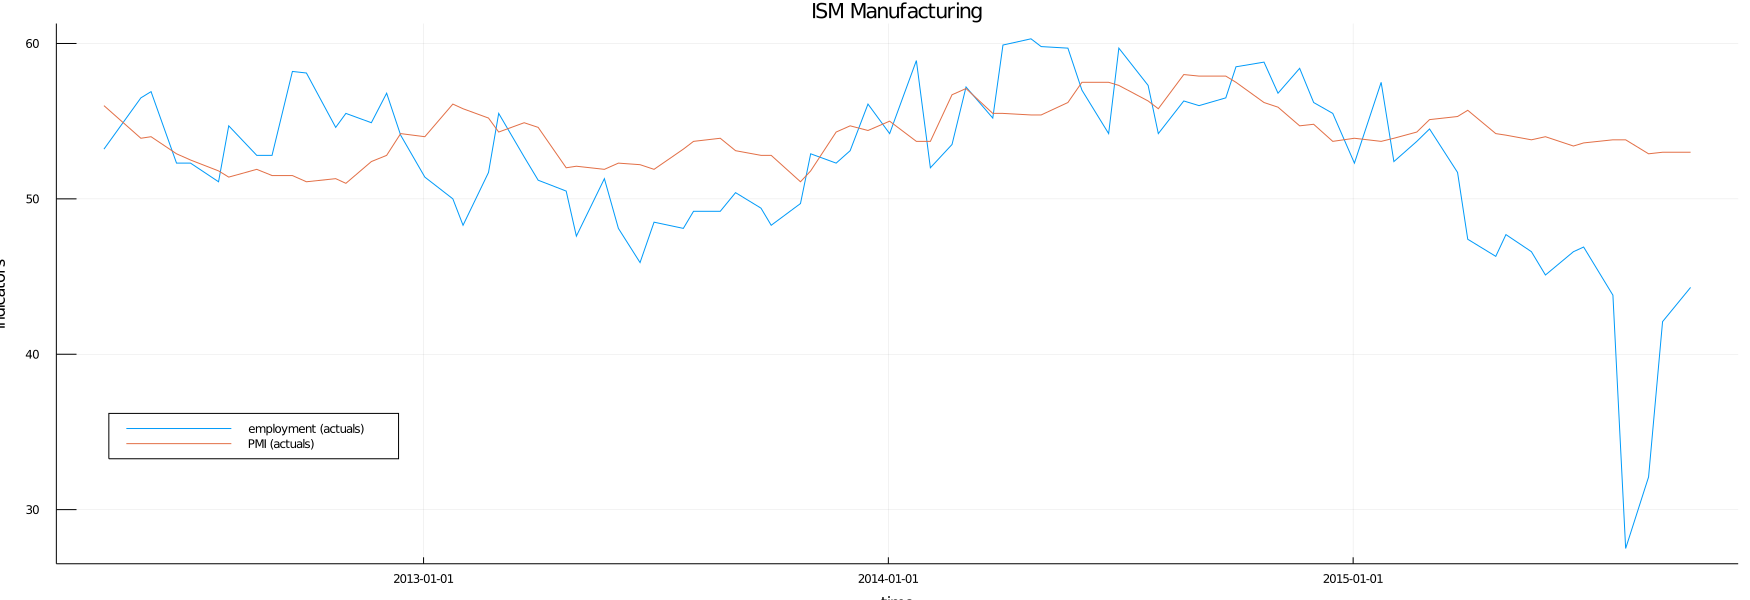

In [67]:
periods = df2[:,1] # all rows, first column
println(periods[begin], " to ", periods[end])
gr()
plot(periods, 
    title="ISM Manufacturing",
    [df1[:,2]  df2[:,2]], 
    label    = ["employment (actuals)" "PMI (actuals)"],
    legend    =:bottomleft, # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (1750, 600), # width, height
    layout = (1, 1) # number of seperate plots VERTICALLY, HORIZONTALLY
    )

# Shift Employment by 90 days back

In [89]:
df3 = df_ISM_Mfc_Emp[:,1:2] # all rows, columns: Date and Actuals
df3 = shift_dates_by_days!(df3, -90, 1)

original 2020-08-03 -90 shift 2020-05-05
original 2020-07-01 -90 shift 2020-04-02
original 2020-06-01 -90 shift 2020-03-03
original 2020-05-01 -90 shift 2020-02-01
original 2020-04-01 -90 shift 2020-01-02
original 2020-03-02 -90 shift 2019-12-03
original 2020-02-03 -90 shift 2019-11-05
original 2020-01-03 -90 shift 2019-10-05
original 2019-12-02 -90 shift 2019-09-03
original 2019-11-01 -90 shift 2019-08-03
original 2019-10-01 -90 shift 2019-07-03
original 2019-09-03 -90 shift 2019-06-05
original 2019-08-01 -90 shift 2019-05-03
original 2019-07-01 -90 shift 2019-04-02
original 2019-06-03 -90 shift 2019-03-05
original 2019-05-01 -90 shift 2019-01-31
original 2019-04-01 -90 shift 2019-01-01
original 2019-03-01 -90 shift 2018-12-01
original 2019-02-01 -90 shift 2018-11-03
original 2019-01-03 -90 shift 2018-10-05
original 2018-12-03 -90 shift 2018-09-04
original 2018-11-01 -90 shift 2018-08-03
original 2018-10-01 -90 shift 2018-07-03
original 2018-09-04 -90 shift 2018-06-06
original 2018-08

,Date,ActualValue
,Date,Float64
1,2020-05-05,44.3
2,2020-04-02,42.1
3,2020-03-03,32.1
4,2020-02-01,27.5
5,2020-01-02,43.8
6,2019-12-03,46.9
7,2019-11-05,46.6
8,2019-10-05,45.1
9,2019-09-03,46.6


82

2015-09-23 to 2012-04-25


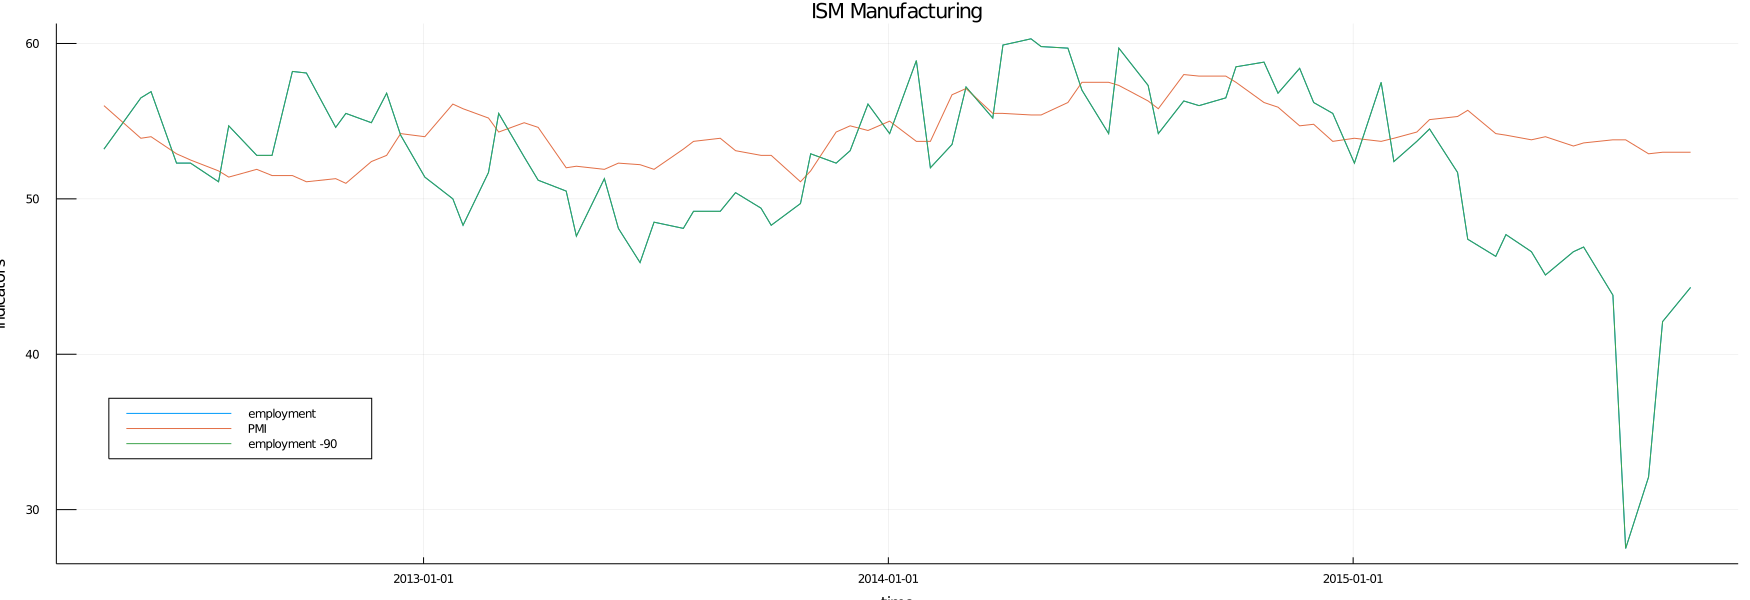

In [92]:
periods = df2[:,1] # all rows, first column
println(periods[begin], " to ", periods[end])
gr()
plot(periods, 
    title="ISM Manufacturing",
    [df1[:,2]  df2[:,2] df3[:,2]], 
    label    = ["employment" "PMI" "employment -90"],
    legend    =:bottomleft, # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (1750, 600), # width, height
    layout = (1, 1) # number of seperate plots VERTICALLY, HORIZONTALLY
    )

# Extract Data

In [ ]:
# rotate the matrix (switch columns to rows) - does not work on DataFrame)
# data = data' 

## Extract Independent Variables (i.e. features)

In [ ]:
x = rawdata[1:13,:]     # independent variables: all rows before last

## Extract Dependent Variable (i.e. price)

In [ ]:
y = rawdata[14:14,:]          # Dependent Variable (price) last ROW

# Normalize the data

## Show mean() values 

Calculate mean values for each feature in the 2-dimentional matrix.

In [ ]:
mean(x, dims = 2)

## Show std() values 

Calculate sample standard deviation (STD).

- https://docs.julialang.org/en/v1/stdlib/Statistics/

In [ ]:
std(x, dims = 2) 

## Normalize the independent variables

In [ ]:
x = (x .- mean(x, dims = 2)) ./ std(x, dims = 2) # math on 13× Arrays

In [ ]:
records = size(x,2) # number of columns

In [ ]:
args = Hyperparams()

In [ ]:
split_ratio = args.split_ratio

split_index = floor(Int, records * split_ratio)

In [ ]:
x_train = x[:,1:split_index]           # training features
y_train = y[:,1:split_index]           # training results
x_test = x[:,split_index+1:records]  # testing features
y_test = y[:,split_index+1:records]  # testing results

In [ ]:
train_data = (x_train, y_train) # tuples
test_data = (x_test, y_test)
size(test_data[1])

In [ ]:
function get_processed_data(args) # expects struct Hyperparams

    isfile("housing.data") ||
        download(
            "https://raw.githubusercontent.com/MikeInnes/notebooks/master/housing.data",
            "housing.data")

    rawdata = readdlm("housing.data")'

    # The last feature is our target -- the price of the house.
    split_ratio = args.split_ratio # For the train/test split

    x = rawdata[1:13,:]
    y = rawdata[14:14,:]

    # Normalise the data
    x = (x .- mean(x, dims = 2)) ./ std(x, dims = 2)

    # Split into train and test sets
    split_index = floor(Int,size(x,2)*split_ratio)
    x_train = x[:,1:split_index]
    y_train = y[:,1:split_index]
    x_test = x[:,split_index+1:size(x,2)]
    y_test = y[:,split_index+1:size(x,2)]

    train_data = (x_train, y_train)
    test_data = (x_test, y_test)

    return train_data,test_data
end

In [ ]:
# Struct to define model
mutable struct model
    W::AbstractArray
    b::AbstractVector
end

In [ ]:
# Function to predict output from given parameters

predict(x, m) = m.W*x .+ m.b

# Mean Squared Error (MSE)

<center><span style="font-size:x-large;" >$ MSE = \sum \limits _{i=1} ^{n} {   \frac{(ŷ_i - y)^2}{n} }$</span></center>

In [ ]:
n = size(y, 2) # e.g. 505 columns

# Mean Squared Error
meansquarederror(ŷ, y) = sum((ŷ .- y).^2)/n

In [ ]:
function train(; kws...)
    # Initialize the Hyperparamters
    args = Hyperparams(; kws...)
    
    # Load the data
    (x_train,y_train),(x_test,y_test) = get_processed_data(args)
    
    test_data = (x_test,y_test)
    
    # The model
    m = model((randn(1,13)),[0.])
    
    loss(x, y) = meansquarederror(predict(x, m), y)

    ## Training
    η = args.learning_rate
    θ = params([m.W, m.b])

    for i = 1:1000
      g = gradient(() -> loss(x_train, y_train), θ)
      for x in θ
        update!(x, -g[x]*η)
      end
      if i%100==0
          @show loss(x_train, y_train)
        end
    end
    
    # Predict the RMSE on the test set
    err = meansquarederror(predict(x_test, m),y_test)
    println("error: ", err)
    return m , test_data# model
end

In [ ]:
cd(@__DIR__)
resulting_model, test_data = train()
resulting_model.W

In [ ]:
resulting_model.b

In [ ]:
function test(model, test)
    # Testing model performance on test data 
    X_test, y_test = test
    #accuracy_score = accuracy(X_test, y_test, model)

    #println("\nAccuracy: $accuracy_score")

    # Sanity check.
    #@assert accuracy_score > 0.8

    # To avoid confusion, here is the definition of a Confusion Matrix: https://en.wikipedia.org/wiki/Confusion_matrix
    println("\nConfusion Matrix:\n")
    #display(confusion_matrix(X_test, y_test, model))
end

In [ ]:
test(model, test_data)
features = test_data[1]

In [ ]:
one_record = features[:,1]

In [ ]:
results = test_data[1][1,:]

In [ ]:
records = size(results)[1]

In [ ]:
get_price(data, model) = model.W * data .+ model.b

In [ ]:
get_price(one_record, resulting_model)

In [ ]:
for i in 1:records # 455
    record = features[:,i] # 13-element Array{Float64,1}:
    result = get_price(record, resulting_model)
    println(i, " ", result, " =? ", results[1])
end